# Epileptic seizure detection



# 1. Data preprocessing

## 1.1. Exploration

In [2]:
# The code was removed by Watson Studio for sharing.

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


The dataset consists of labeled timeseries. Each row corresponds to one second of brain activity EEG recording for one individual.

In [3]:
import numpy as np 
import pandas as pd
import math

# check for missing values
missing_value_count_by_column=(epi.isnull().sum())
print ('Number of missing values: ', missing_value_count_by_column.sum())
print('Shape of dataframe: ', epi.shape)

# get the distribution of classes
print ('\n Labels distribution: \n ')
print(epi['y'].value_counts())



Number of missing values:  0
Shape of dataframe:  (11500, 180)

 Labels distribution: 
 
5    2300
4    2300
3    2300
2    2300
1    2300
Name: y, dtype: int64


## 1.2. Visualizations

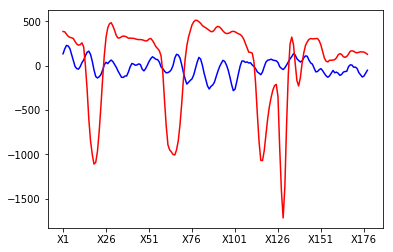

In [5]:

import matplotlib.pyplot as plt
import seaborn as sns
# visualize two of the samples
epi.iloc[0, 1:179].plot( color="blue") # 'no seizure' sample
epi.iloc[1, 1:179].plot(color='red')  # 'seizure' sample


Since each sample is a discrete time signal of length N=178, we can consider applying Discrete Fourier transform. 
Applying Fast Fourier transform to a discrete signal of length N, returns complex numbers X[0], X[1],..,X[N-1] that are the contributions of the complex sinuosids exp(2pi*j*0/N), exp(2pi*j*1/N),..,exp(2pi*j*(N-1)/N) in the signal. 

Let's obtain the Fourier transforms of the two samples and visualize their magnitudes.

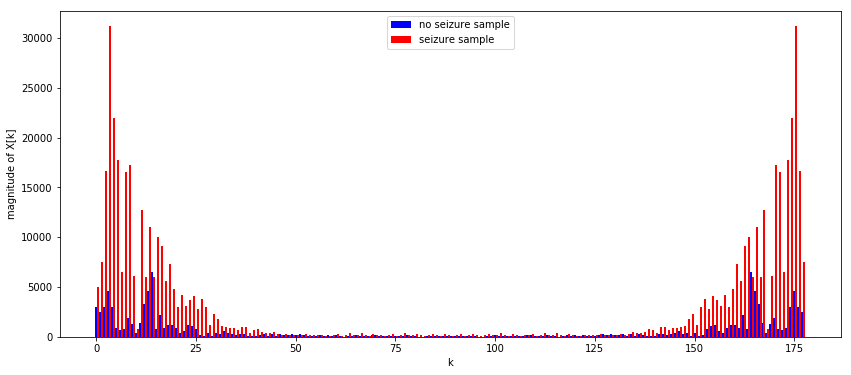

In [7]:
no_seizure_sample= np.fft.fft(epi.iloc[0,1:179])  
seizure_sample = np.fft.fft(epi.iloc[1,1:179])  

N = 178 # length of timeseries

ind = np.arange(N) 
width = 0.5  

plt.figure(figsize=(14, 6))
plt.bar(ind, abs(no_seizure_sample), width, color='blue', label='no seizure sample')
plt.bar(ind + width, abs(seizure_sample), width, color='red',
    label='seizure sample')

plt.ylabel('magnitude of X[k]')
plt.xlabel ('k')
plt.xticks(np.arange(0, 178, step=25))

plt.legend(loc="upper center")
plt.show()

The symmetry is explained by the fact that X[k] is the complex conjugate of X[N-k] and so, the magnitude of X[k] is equal to the magnitude of X[N-k].

## 1.3. Feature creation

Because we want to do binary classification, we combine labels '2', '3', '4', '5' into one class denoted '0' corresponding to 'no seizure'. Moreover, class '1' is for 'seizure'.

In [33]:
label=(epi['y']==1)*1    # create a vector of labels, class 1 is for samples during seizures, class 0 is for samples during normal brain activity
print ('No seizure samples: ', (label==0).sum() )  # number of 'no seizure' samples
print ('Seizure samples: ', (label==1).sum() )    # number of 'seziure' samples

No seizure samples:  9200
Seizure samples:  2300


Since each row  [X1, X2,.., X178] represents a discrete finite signal, we apply Fast Fourier transform to each row to obtain a corresponding sequence of complex numbers denoted by X[0], X[1],..,X[177]. The features that we train the models on will be the magnitudes of these Fourier transforms.

In fact, we consider only the magnitudes of X[0],..X[89], because of the property that abs(X[k])=abs(X[N-k]).
This way, we obtain 90 real valued features.

Below we write a function which performs the above steps: it applies Fast Fourier transform to each row in a numpy array, computes the magnitudes of half of the resulting sequence, stacks the results as rows of a 2d numpy array and performs scaling across columns. This new array will be used  for training the models.

In [2]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# apply fft across rows, compute magnitudes 
def fft_scale(data):  
    N=int(data.shape[1]/2)+1  #  because of symmetry 
    df=np.array([range(N)]) # initialize the first row in an array where we will store the results
    for i in range(data.shape[0]):
        row=data[i,:]
        row_fft = abs(np.fft.fft(row)[0:N]) # compute magnitudes
        df=np.vstack([df, row_fft.reshape(1,-1)]) # reshape(1,-1) gives a row vector
    df_scaled=scaler.fit_transform(df[1:,:]) # scale array across columns
    return df_scaled





We apply the function on our data corresponding to the columns X1,..,X178 in the initial dataset.

In [35]:
features=epi.iloc[:, 1:179] # we select only the feature columns, disregard column 179 which contains the labels

data= fft_scale(features.values)  # numpy array containing 11500 rows with 90 numerical values each
data.shape


(11500, 90)

# 2. Model implementation

In [36]:
# we create training and testing sets
from sklearn.model_selection import train_test_split

validation_size=0.08 
seed=1  

# random splitting into training and testing sets
X_train_fft, X_test_fft, label_train, label_test=train_test_split(data,label,test_size=validation_size, random_state=seed)
print('Number of negatives in the test set: ', (label_test==0).sum())
print('Number of positives in the test set: ', (label_test==1).sum())

Number of negatives in the test set:  730
Number of positives in the test set:  190


We look at the distribution of negative ('0') and positive ('1') events in the test set X_test_fft because this will be important when deciding how to measure accuracy of the models on the test set.

## 2.1 Supervised learning model : XGBClassifier

In [126]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


model = XGBClassifier()
model.fit(X_train_fft, label_train)

# obtain the predictions for the test set
y_pred = model.predict(X_test_fft)
predictions = [round(value) for value in y_pred]


We now evaluate the accuracy of the model on the test set. Since the distribution of the two classes, 0 and 1 in the test set is highly unbalanced, we use a weighted formula: accuracy=[# true positive predictions/#positive samples + # true negative predictions/#negative samples]/2

In [127]:
from sklearn.metrics import confusion_matrix

m=confusion_matrix(label_test, predictions)

accuracy=0.5*(m[0,0]/(m[0,0]+m[0,1])+ m[1,1]/(m[1,1]+m[1,0]))

print("Confusion matrix: \n", m)
print( "Accuracy on test data: ", accuracy)

Confusion matrix: 
 [[722   8]
 [  5 185]]
Accuracy on test data:  0.981362653208


Depending on the objective, we may prefer precision or recall as indicators of accuracy.

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
In other words, out of those events classified as seizures, what percentage are true seizures? 

In [128]:
precision=m[1,1]/(m[0,1]+m[1,1])
print("Precision: ", precision)

Precision:  0.958549222798


The recall is given by the formula tp/(tp+fn). Equivalently, out of all true seizures, what percentage are detected?

In [129]:
recall=m[1,1]/(m[1,1]+m[1,0])
print("Recall: ", recall) 



Recall:  0.973684210526


The f1-score is another measure of accuracy and it combines precision and recall. A value close to 1 is ideal.

In [130]:
from sklearn.metrics import f1_score
score=f1_score(label_test, y_pred, average='weighted')
print("The f1 score is: ", score)

The f1 score is:  0.985910358884


## 2.2. Deep learning model: Autoencoder

We train an autoencoder to learn to reconstruct the 'no seizure'('0') samples in the training data X_train_fft. Then, we apply it on the test set, which contains both 1 and 0 labeled samples. So, the autoencoder sees 'seizure'('1') samples only at test time. 

We expect the reconstruction errors for 'seizure' samples to differ signifficantly from those of  'no seizure' samples. If the error for a sample in the test set is above a certain threshold, we will classify it as a seizure event.

First, we create the training data for the autoencoder. It consists of the 'no seizure'('0') samples from X_train_fft.

In [37]:
# we find the indices of the samples labeled '0' from X_train_fft
Z=pd.DataFrame(label_train).reset_index()

indices= list(Z[Z['y']==0].index)

# we select those negative ('0') samples 
autoencoder_train=pd.DataFrame(X_train_fft).iloc[indices,:].values 

autoencoder_train.shape

(8470, 90)

So, the training data for the autoencoder consists of 8470 negative samples and 90 features. The test data for the autoencoder remains the same as before, X_fft_test.

In [38]:
autoencoder_test=X_test_fft # test set for autoencoder

print('Shape of autoencoder train data: \n', autoencoder_train.shape)
print('Shape of autoencoder test data: \n', autoencoder_test.shape)

Shape of autoencoder train data: 
 (8470, 90)
Shape of autoencoder test data: 
 (920, 90)


### Autoencoder architecture:
    
-input layer:encoding_dim=90, layer1: encoding_dim/2 nodes, layer2: encoding_dim/3 nodes, layer3: encoding_dim/2 nodes, layer4: encoding_dim nodes.

In [39]:
import tensorflow as tf
import seaborn as sns

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard


input_dim = autoencoder_train.shape[1]
encoding_dim = input_dim

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(encoding_dim/2), activation="relu")(input_layer) 
encoder = Dense(int(encoding_dim/3), activation="relu")(encoder)
decoder=Dense(int(encoding_dim/2), activation='relu')(encoder)
decoder=Dense(input_dim, activation="relu")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)



Using TensorFlow backend.


### Autoencoder training:

In [40]:
nb_epoch = 100 
batch_size = 10


autoencoder.compile(optimizer='adam', 
                    loss='mse')
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(autoencoder_train, autoencoder_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(autoencoder_test, autoencoder_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history







Train on 8470 samples, validate on 920 samples
Epoch 1/100
8470/8470 [==============================] - 4s 424us/step - loss: 5.1456e-04 - val_loss: 0.0023
Epoch 2/100
8470/8470 [==============================] - 4s 436us/step - loss: 3.4920e-04 - val_loss: 0.0021
Epoch 3/100
8470/8470 [==============================] - 4s 434us/step - loss: 2.9687e-04 - val_loss: 0.0018
Epoch 4/100
8470/8470 [==============================] - 4s 424us/step - loss: 2.6675e-04 - val_loss: 0.0017
Epoch 5/100
8470/8470 [==============================] - 4s 433us/step - loss: 2.5595e-04 - val_loss: 0.0016
Epoch 6/100
8470/8470 [==============================] - 4s 435us/step - loss: 2.4888e-04 - val_loss: 0.0016
Epoch 7/100
8470/8470 [==============================] - 4s 423us/step - loss: 2.4180e-04 - val_loss: 0.0015
Epoch 8/100
8470/8470 [==============================] - 4s 429us/step - loss: 2.4154e-04 - val_loss: 0.0015
Epoch 9/100
8470/8470 [==============================] - 4s 424us/step - loss: 2.

In [47]:
autoencoder=load_model('model.h5') 
autoencoder.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 90)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 45)                4095      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1380      
_________________________________________________________________
dense_3 (Dense)              (None, 45)                1395      
_________________________________________________________________
dense_4 (Dense)              (None, 90)                4140      
Total params: 11,010
Trainable params: 11,010
Non-trainable params: 0
_________________________________________________________________


Text(0.5,0,'epoch')

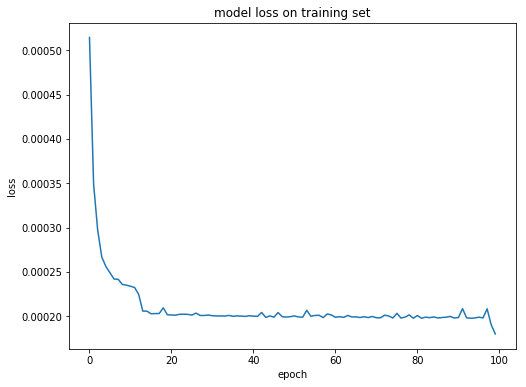

In [58]:
# visualise loss on training set 
plt.figure(figsize=(8, 6))
plt.plot(history['loss'])

plt.title('model loss on training set')
plt.ylabel('loss')
plt.xlabel('epoch')


Text(0.5,0,'epoch')

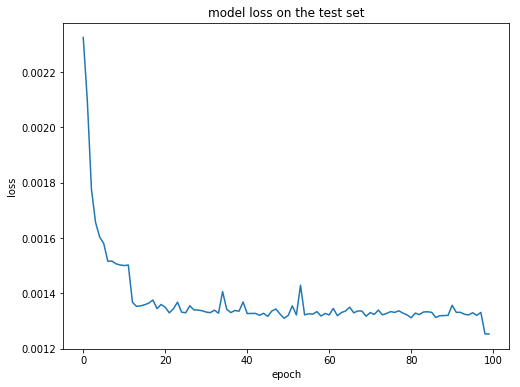

In [59]:
# visualise loss on test set during training
plt.figure(figsize=(8, 6))
plt.plot(history['val_loss'])
plt.title('model loss on the test set')
plt.ylabel('loss')
plt.xlabel('epoch')

The model loss on the test data is quite erratic, but this is to be expected, since the autoencoder sees positive samples only at test time.

Now we want to measure how well the autoencoder reconstructs the samples in the test data.

### Autoencoder performance: 

For each sample in the test set, we compare the reconstruction given by the autoencoder with the actual value.

In [60]:
predictions = autoencoder.predict(autoencoder_test)

mse = np.mean(np.power(autoencoder_test - predictions, 2), axis=1) # we average the sum of squares of differences between the predicted samples and real samples
error_df = pd.DataFrame({'reconstruction_error': mse,      # we create a dataframe with these errors together with the true labels for the samples
                        'true_class': label_test})    

error_df.head()



,reconstruction_error,true_class
2663,0.000022,0
8871,0.009321,1
8684,0.000467,1
2061,0.003566,1
7258,0.000051,0


We expect that the reconstruction errors for the positive('1') samples are, on average, greater than the reconstruction errors for the negative('0') samples in the test set.

Below, we visualize the errors for the two classes, separately.

,reconstruction_error,true_class
count,730.000000,730.0
mean,0.000176,0.0
std,0.000326,0.0
min,0.000011,0.0
25%,0.000053,0.0
50%,0.000103,0.0
75%,0.000189,0.0
max,0.006717,0.0


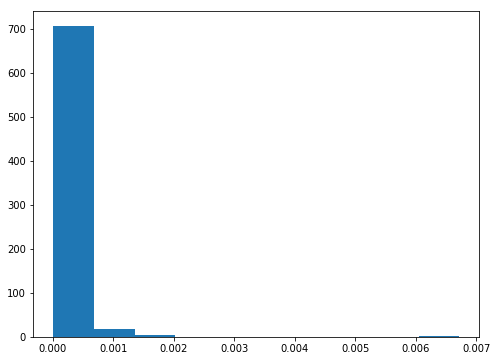

In [63]:
# plot a histogram of the reconstruction errors for the negative ('no seizure') samples in the test set

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

noseizure_error_df = error_df[(error_df['true_class']== 0)]
_ = ax.hist(noseizure_error_df.reconstruction_error.values, bins=10)

noseizure_error_df.describe()

,reconstruction_error,true_class
count,190.000000,190.0
mean,0.005393,1.0
std,0.007057,0.0
min,0.000100,1.0
25%,0.000706,1.0
50%,0.002531,1.0
75%,0.007322,1.0
max,0.047250,1.0


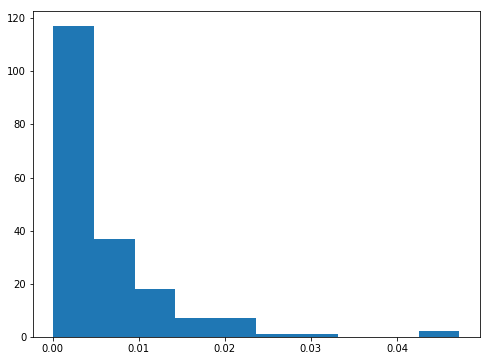

In [64]:
# plot a histogram of the reconstruction errors for the positive ('seizure') samples in the test set

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
seizure_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(seizure_error_df.reconstruction_error.values, bins=10)

seizure_error_df.describe()

As we expected, the autoencoder overall gives worse reconstructions for the positive samples than for the negative ones. The mean of the errors for negative samples is 0.000176 while for positive samples is 0.005393. 	

 We need to choose a threshold t such that if reconstruction error<t then we label the sample as '0', else we label it as '1'.

Using the histograms, we can experiment with a few choices for the threshold.

In [101]:
threshold= 0.00044 

#we label the test samples accordingly
Y_pred = [1 if e > threshold else 0 for e in error_df['reconstruction_error'].values]



Let's obtain the confusion matrix for these assigned labels versus the actual labels of the samples in the test set.

In [102]:
from sklearn.metrics import confusion_matrix

mat=confusion_matrix(label_test, Y_pred)
print("confusion matrix for the predictions:\n ", mat)


confusion matrix for the predictions:
  [[688  42]
 [ 22 168]]


The distribution of the two classes, '0'('negative') and '1'('positive') in the test set is highly unbalanced, so to measure the accuracy of the model from the consusion matrix, we use the weighted formula: accuracy=[# true positive predictions/#positive samples+# true negative predictions/#negative samples]/2

In [103]:
accuracy=0.5*(mat[0,0]/(mat[0,0]+mat[0,1])+ mat[1,1]/(mat[1,1]+mat[1,0]))
print( "Accuracy on test data: ", accuracy)


Accuracy on test data:  0.91333813987


Out of those events classified as seizures, what percentage are true seizures? 

In [104]:
precision=mat[1,1]/(mat[0,1]+mat[1,1])        
print("precision: ", precision)

precision:  0.8


What percentage of the true seizures were detected by the model predictions?

In [105]:
recall=mat[1,1]/(mat[1,1]+mat[1,0])
print("recall: ", recall)  

recall:  0.884210526316


# Conclusion

Discrete Fourier transform was used to trasform each timeseries(row in the dataset) into a collection of sequences that would produce features for training the models on. 

We trained a machine learning classifier- XGBoost and a deep learning regressor-autoencoder.

The XGBoost classifier had better results across all three evaluation measures: accuracy, precision and recall than the autoencoder with the specific architecture described in section 2.2.
We might improve the performance of the autoencoder if we experiment with different architectures, but even with the simple architecture considered in this project, we still obtained some good results.


# References


https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

https://lpsa.swarthmore.edu/Fourier/Xforms/FXformIntro.html